# Interpretasi Hasil Model

>## import library

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt

import joblib
import shap

In [4]:
import sklearn
print(sklearn.__version__)


1.6.1


>## impor model & dataset

In [6]:
df = pd.read_csv('DataFrame_processed/DataFrame_processed.csv')
X = df.drop(columns=["Attrition"])
y = df["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
# Logistic Regression
logreg = joblib.load("models/logreg_tuned.pkl")

# Decision Tree Classifier
tree = joblib.load("models/tree_tuned.pkl")

# Bagging Classifier
bagging = joblib.load("models/bagging_tuned.pkl")

# Adaboost Classifier
adaboost = joblib.load("models/boost_tuned.pkl")

# XGboost Classifier
xgb = joblib.load("models/xgboost_tuned.pkl")

# Stacking
stack = joblib.load("models/stack_tuned.pkl")

C:\Users\Lenovo\anaconda3\Lib\pickle.py:1710: UserWarning: [15:11:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [8]:
from xgboost import XGBClassifier

xgb_loaded = XGBClassifier()
xgb_loaded.load_model("models/xgb_tuned_model_only.json")

prep = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), selector(dtype_exclude=np.number)),
    ],
    remainder="drop"
)

# XGboost Classifier
xgb_pipe = ImbPipeline(steps=[
    ("prep", prep),
    ("smote", SMOTETomek(random_state=42)),
    ("clf", xgb_loaded)
])

## MODEL 1 - LOGISTIC REGRESSION

In [10]:
logreg.fit(X_train, y_train)
y_pred  = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.9363    0.7733    0.8470       247
           1     0.3778    0.7234    0.4964        47

    accuracy                         0.7653       294
   macro avg     0.6570    0.7483    0.6717       294
weighted avg     0.8470    0.7653    0.7909       294

Test ROC-AUC: 0.8002
Test F2: 0.6115107913669064


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


>### Feature Importance

In [12]:
feature_names = logreg[0].get_feature_names_out()

In [13]:
model = logreg.named_steps["clf"]
coefs = model.coef_[0]
feat_importances = pd.Series(np.abs(coefs), index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

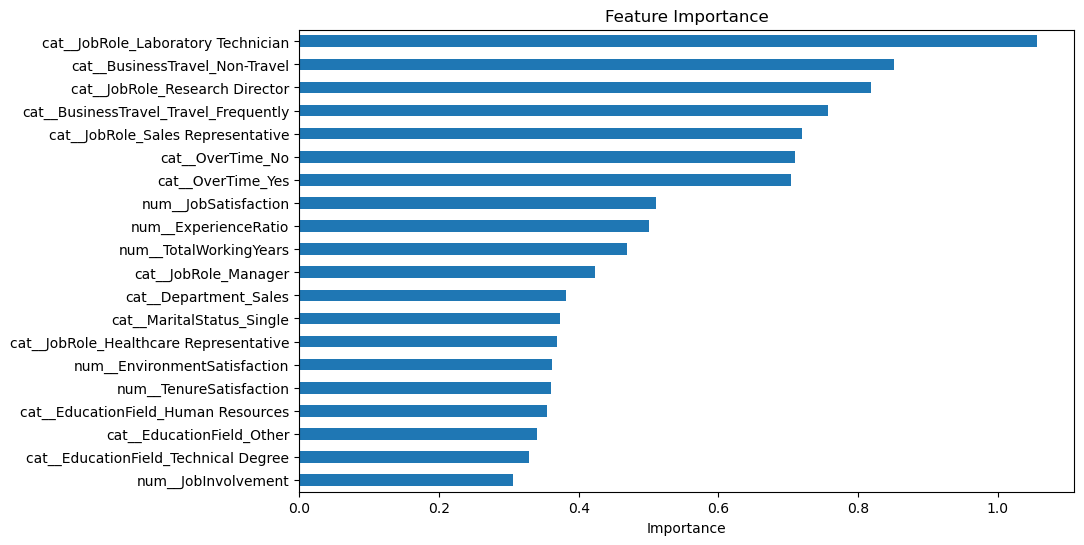

In [14]:
plt.figure(figsize=(10,6))
feat_importances.head(20).plot(kind="barh")  # top 20 biar tidak terlalu ramai
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

>### SHAP Values

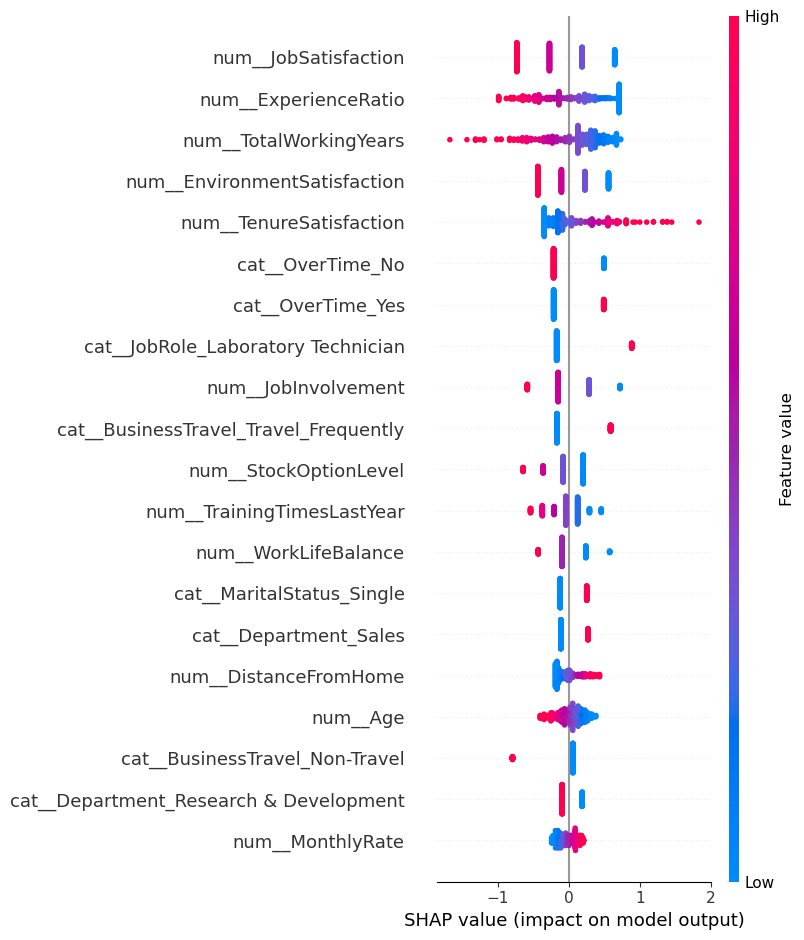

In [16]:
# Ambil preprocessing step
preprocessor = logreg.named_steps['prep']

# Transform X_train dan X_test ke bentuk numerik
preprocessed_X_train = preprocessor.transform(X_train)
preprocessed_X_test  = preprocessor.transform(X_test)

# Ambil model (clf) untuk SHAP
model_logreg = logreg.named_steps['clf']

# Buat explainer
explainer_logreg = shap.Explainer(model_logreg, preprocessed_X_train)
shap_value_logregs = explainer_logreg(preprocessed_X_test)

# Plot
shap.summary_plot(shap_value_logregs, preprocessed_X_test, feature_names=preprocessor.get_feature_names_out())


>### Bias & Fairness Analysis

In [18]:
# === 2. Prediksi pakai model ===
y_pred = logreg.predict(X_test)
y_true = y_test.copy()

df_eval = X_test.copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred

# === 3. Tambahkan IncomeGroup (Low, Mid, High) ===
df_eval["IncomeGroup"] = pd.qcut(
    df_eval["MonthlyIncome"],
    q=3,
    labels=["Low", "Mid", "High"]
)

# === 4. Ambil estimator terakhir dari pipeline ===
try:
    final_est = logreg.named_steps[list(logreg.named_steps.keys())[-1]]
except:
    final_est = logreg

# === 5. Ambil feature names dari preprocessing ===
try:
    preprocessor = logreg.named_steps[list(logreg.named_steps.keys())[0]]
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
except:
    feature_names = X_test.columns

# === 6. Ambil importance / coef ===
try:
    importances = pd.Series(final_est.feature_importances_, index=feature_names)
except AttributeError:
    try:
        importances = pd.Series(abs(final_est.coef_[0]), index=feature_names)
    except AttributeError:
        importances = pd.Series([0] * len(feature_names), index=feature_names)

top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print("Top 3 Features (by importance):", top_features)

# === 7. Faktor bisnis utama ===
business_features = ["OverTime", "MonthlyIncome", "JobRole", "IncomeGroup"]
features_to_check = list(set(top_features + business_features))
print("Features to check fairness:", features_to_check)

# === 8. Uji fairness ===
results = {}
for feat in features_to_check:
    if feat not in df_eval.columns:
        continue
    results[feat] = {}
    for group, subset in df_eval.groupby(feat):
        if len(subset) > 5:
            report = classification_report(
                subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
            )
            results[feat][group] = report["weighted avg"]

# === 9. Print hasil ===
for feat, groups in results.items():
    print(f"\n=== Fairness check by {feat} ===")
    for group, metrics in groups.items():
        print(f"  {group}: F1={metrics['f1-score']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

Top 3 Features (by importance): ['cat__JobRole_Laboratory Technician', 'cat__BusinessTravel_Non-Travel', 'cat__JobRole_Research Director']
Features to check fairness: ['IncomeGroup', 'cat__BusinessTravel_Non-Travel', 'OverTime', 'MonthlyIncome', 'cat__JobRole_Research Director', 'JobRole', 'cat__JobRole_Laboratory Technician']

=== Fairness check by IncomeGroup ===
  Low: F1=0.741, Precision=0.800, Recall=0.724
  Mid: F1=0.764, Precision=0.861, Recall=0.724
  High: F1=0.863, Precision=0.883, Recall=0.847

=== Fairness check by OverTime ===
  No: F1=0.839, Precision=0.896, Recall=0.803
  Yes: F1=0.658, Precision=0.719, Recall=0.658

=== Fairness check by MonthlyIncome ===

=== Fairness check by JobRole ===
  Healthcare Representative: F1=0.893, Precision=0.921, Recall=0.913
  Human Resources: F1=0.747, Precision=0.777, Recall=0.727
  Laboratory Technician: F1=0.673, Precision=0.926, Recall=0.591
  Manager: F1=1.000, Precision=1.000, Recall=1.000
  Manufacturing Director: F1=0.791, Preci

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\1124028216.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df_eval.groupby(feat):


## MODEL 2 - DECISION TREE

In [20]:
tree.fit(X_train, y_train)
y_pred  = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)


=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.9009    0.7733    0.8322       247
           1     0.3171    0.5532    0.4031        47

    accuracy                         0.7381       294
   macro avg     0.6090    0.6632    0.6177       294
weighted avg     0.8076    0.7381    0.7636       294

Test ROC-AUC: 0.6898
Test F2: 0.48148148148148145


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


>### Feature Importance

In [22]:
model_tree = tree.named_steps["clf"]

importances = model_tree.feature_importances_

feat_importances = pd.Series(importances, index=feature_names)

feat_importances = feat_importances.sort_values(ascending=False)

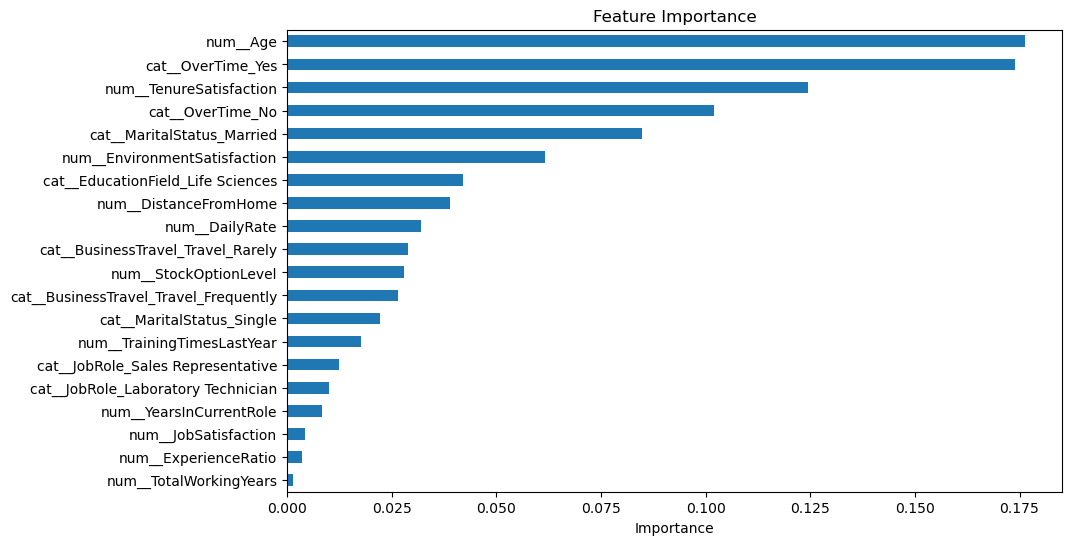

In [23]:
plt.figure(figsize=(10,6))
feat_importances.head(20).plot(kind="barh")  
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

>### SHAP Values

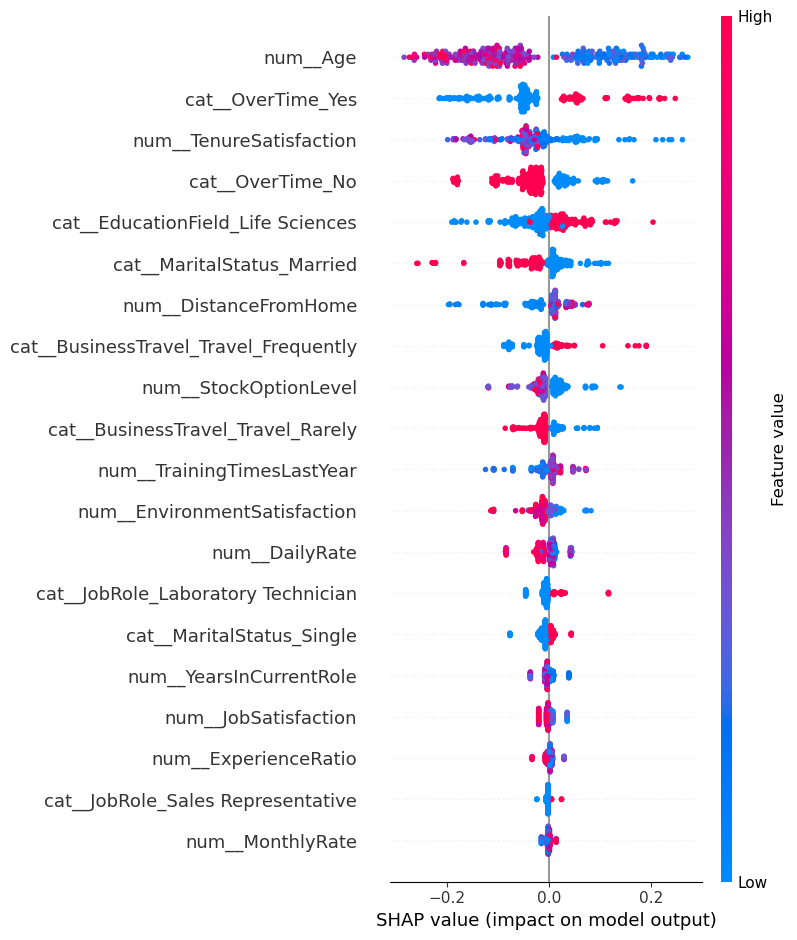

In [25]:

# Ambil model (tree-based) dari pipeline
model_tree = tree.named_steps['clf']   # ganti 'pipe' sesuai pipeline kamu

# Buat TreeExplainer
explainer = shap.TreeExplainer(model_tree)

# Hitung SHAP values
shap_values = explainer.shap_values(preprocessed_X_test)

# Handle berbagai bentuk output
if isinstance(shap_values, list):
    # beberapa model ngasih list per class
    shap_vals = shap_values[1]   # ambil kelas positif
elif shap_values.ndim == 3:
    # kalau array 3D → (n_samples, n_features, n_classes)
    shap_vals = shap_values[:, :, 1] 
else:
    shap_vals = shap_values  # default (n_samples, n_features)

# 6. Plot summary
shap.summary_plot(
    shap_vals,
    preprocessed_X_test,
    feature_names=tree.named_steps['prep'].get_feature_names_out()
)


>### Bias & Fairness Analysis

In [27]:
# === 2. Prediksi pakai model ===
y_pred = tree.predict(X_test)
y_true = y_test.copy()

df_eval = X_test.copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred

# === 3. Buat kategori MonthlyIncome (Low, Mid, High) ===
if "MonthlyIncome" in df_eval.columns:
    df_eval["IncomeGroup"] = pd.qcut(
        df_eval["MonthlyIncome"], q=3, labels=["Low", "Mid", "High"]
    )
else:
    df_eval["IncomeGroup"] = "Unknown"

# === 4. Ambil estimator terakhir dari pipeline ===
try:
    final_est = tree.named_steps[list(tree.named_steps.keys())[-1]]
except:
    final_est = tree

# === 5. Ambil feature names dari preprocessing ===
try:
    preprocessor = tree.named_steps[list(tree.named_steps.keys())[0]]
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
except:
    feature_names = X_test.columns

# === 6. Ambil importance / coef ===
try:
    importances = pd.Series(final_est.feature_importances_, index=feature_names)
except AttributeError:
    importances = pd.Series([0] * len(feature_names), index=feature_names)

top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print("Top 3 Features (by importance):", top_features)

# === 7. Faktor bisnis utama ===
business_features = ["OverTime", "IncomeGroup", "JobRole"]
features_to_check = list(set(top_features + business_features))
print("Features to check fairness:", features_to_check)

# === 8. Uji fairness ===
results = {}
for feat in features_to_check:
    if feat not in df_eval.columns:
        continue
    results[feat] = {}
    for group, subset in df_eval.groupby(feat):
        if len(subset) > 5:
            report = classification_report(
                subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
            )
            results[feat][group] = report["weighted avg"]

# === 9. Print hasil ===
for feat, groups in results.items():
    print(f"\n=== Fairness check by {feat} ===")
    for group, metrics in groups.items():
        print(f"  {group}: F1={metrics['f1-score']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

Top 3 Features (by importance): ['num__Age', 'cat__OverTime_Yes', 'num__TenureSatisfaction']
Features to check fairness: ['IncomeGroup', 'num__Age', 'cat__OverTime_Yes', 'OverTime', 'num__TenureSatisfaction', 'JobRole']

=== Fairness check by IncomeGroup ===
  Low: F1=0.645, Precision=0.703, Recall=0.622
  Mid: F1=0.767, Precision=0.824, Recall=0.735
  High: F1=0.870, Precision=0.885, Recall=0.857

=== Fairness check by OverTime ===
  No: F1=0.823, Precision=0.864, Recall=0.789
  Yes: F1=0.593, Precision=0.642, Recall=0.592

=== Fairness check by JobRole ===
  Healthcare Representative: F1=0.764, Precision=0.745, Recall=0.783
  Human Resources: F1=0.747, Precision=0.777, Recall=0.727
  Laboratory Technician: F1=0.713, Precision=0.856, Recall=0.636
  Manager: F1=0.973, Precision=1.000, Recall=0.947
  Manufacturing Director: F1=0.798, Precision=0.888, Recall=0.750
  Research Director: F1=0.882, Precision=0.882, Recall=0.882
  Research Scientist: F1=0.672, Precision=0.709, Recall=0.653
  

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\3773153661.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df_eval.groupby(feat):


## MODEL 3 - BAGGING CLASSIFIER

In [29]:
bagging.fit(X_train, y_train)
y_pred  = bagging.predict(X_test)
y_proba = bagging.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.8906    0.9555    0.9219       247
           1     0.6207    0.3830    0.4737        47

    accuracy                         0.8639       294
   macro avg     0.7556    0.6692    0.6978       294
weighted avg     0.8474    0.8639    0.8502       294

Test ROC-AUC: 0.8277
Test F2: 0.4147465437788018


>### Feature Importance

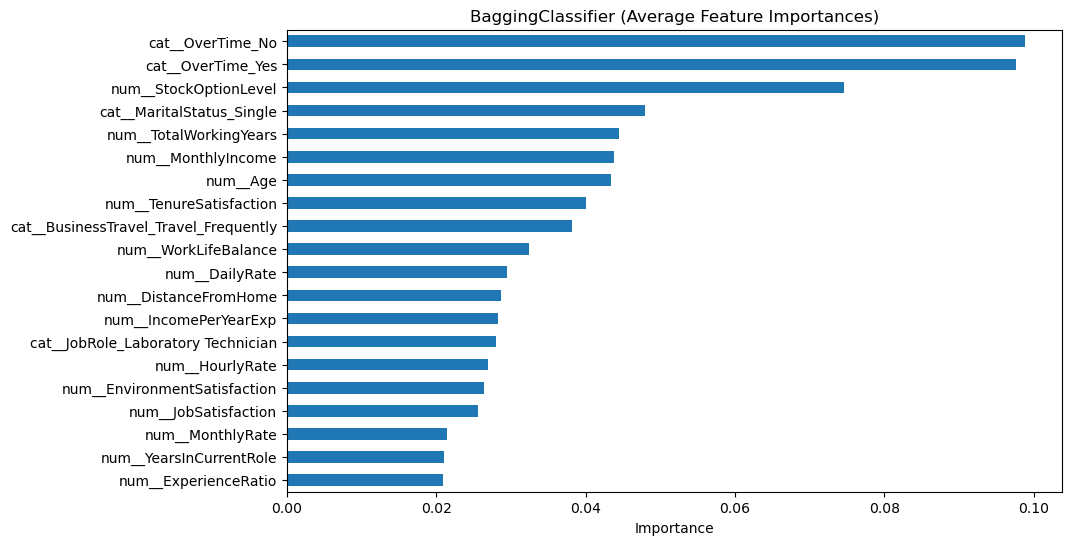

In [31]:
# Ambil preprocessor & feature names dari pipeline
preprocessor = bagging.named_steps["prep"]
feature_names = preprocessor.get_feature_names_out()

# Ambil BaggingClassifier
model_bag = bagging.named_steps["clf"]

all_importances = []

# Loop semua base estimator
for est, feat_idx in zip(model_bag.estimators_, model_bag.estimators_features_):
    imp = np.zeros(len(feature_names))   # panjang sama dengan total feature
    imp[feat_idx] = est.feature_importances_  # isi importance untuk feature yang dipakai
    all_importances.append(imp)

# Rata-rata importance semua estimator
avg_importances = np.mean(all_importances, axis=0)

# Gabungkan ke pandas Series
feat_importances_bag = pd.Series(avg_importances, index=feature_names)

# Urutkan
feat_importances_bag = feat_importances_bag.sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10,6))
feat_importances_bag.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("BaggingClassifier (Average Feature Importances)")
plt.xlabel("Importance")
plt.show()

In [32]:
print(model_bag.max_features)


0.7


>### SHAP Values

In [34]:
def get_shap_general(
    pipeline, 
    X_train, 
    X_test, 
    model_type="tree", 
    n_background=50, 
    method="kmeans", 
    n_test_samples=None,   # <=== baru ditambahkan
    nsample_kernel=10      # <=== supaya juga bisa custom nsample di KernelExplainer
):
    """
    Hitung SHAP values untuk pipeline model (tree-based atau non-tree).

    Parameters
    ----------
    pipeline : sklearn.pipeline.Pipeline
        Pipeline berisi preprocessor + classifier.
    X_train : array-like
        Data training (belum diproses).
    X_test : array-like
        Data testing (belum diproses).
    model_type : str, default="tree"
        "tree"   -> pakai TreeExplainer (XGBoost, RF, LightGBM, dll.)
        "kernel" -> pakai KernelExplainer (LogReg, SVM, AdaBoost, Stacking, Bagging, dll.)
    n_background : int, default=50
        Jumlah background samples untuk KernelExplainer.
    method : str, default="kmeans"
        Metode background -> "kmeans" atau "sample".
    n_test_samples : int or None, default=None
        Jika None, gunakan seluruh X_test.
        Jika angka, gunakan X_test[:n_test_samples].
    nsample_kernel : int, default=10
        Jumlah sample Monte Carlo untuk KernelExplainer (trade-off speed vs akurasi).
    """

    # ambil preprocessor (step pertama) dan classifier (step terakhir)
    preprocessor = list(pipeline.named_steps.values())[0]
    clf = list(pipeline.named_steps.values())[-1]

    # transformasi data
    X_train_proc = preprocessor.transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    # kalau ada limit sample test
    if n_test_samples is not None:
        X_test_proc = X_test_proc[:n_test_samples]

    # === Tree-based model (XGBoost, RF, GBM, dll.) ===
    if model_type == "tree":
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test_proc)

        # handle binary/multiclass
        if isinstance(shap_values, list):  
            shap_vals = shap_values[1]  # kelas positif
        elif shap_values.ndim == 3:
            shap_vals = shap_values[:, :, 1]
        else:
            shap_vals = shap_values

    # === Non-tree model (AdaBoost, Bagging, Stacking, LogReg, SVM, dll.) ===
    elif model_type == "kernel":
        # pilih background data
        if method == "kmeans":
            background = shap.kmeans(X_train_proc, n_background)
        elif method == "sample":
            background = shap.sample(X_train_proc, n_background)
        else:
            raise ValueError("method harus 'kmeans' atau 'sample'")

        explainer = shap.KernelExplainer(clf.predict_proba, background, progress_message=True)
        shap_values = explainer.shap_values(X_test_proc, nsamples=nsample_kernel)

        # handle binary/multiclass
        if isinstance(shap_values, list):
            shap_vals = shap_values[1]
        elif shap_values.ndim == 3:
            shap_vals = shap_values[:, :, 1]
        else:
            shap_vals = shap_values
    else:
        raise ValueError("model_type harus 'tree' atau 'kernel'")

    return explainer, shap_vals, X_test_proc


In [35]:
expl_bag, shap_bag, X_test_bag = get_shap_general(
    pipeline=bagging, 
    X_train=X_train, 
    X_test=X_test, 
    model_type="kernel",    # karena Bagging bukan tree-explainer murni
    n_background=200, 
    method="sample",
    n_test_samples=200,
    nsample_kernel=50 # lebih cepat dari kmeans
)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.144e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.713e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.168e-02, with an active set of 4 regressors, and the smallest cholesky pivot ele

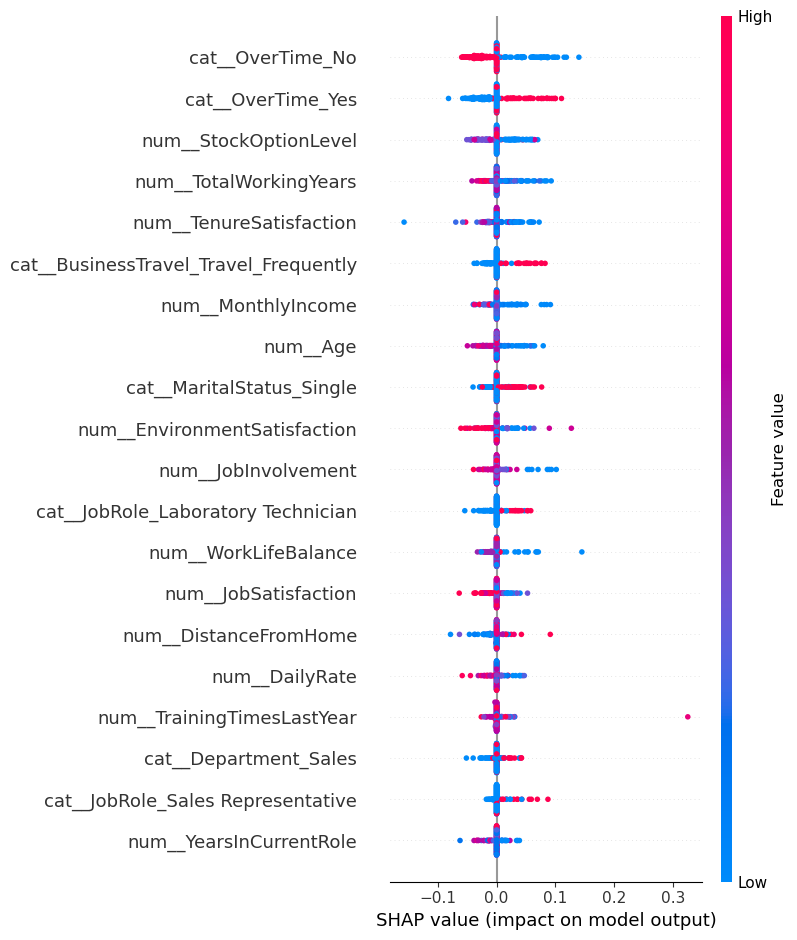

In [36]:
shap.summary_plot(
    shap_bag, 
    X_test_bag[:200],                        # bisa ganti slice sesuai kebutuhan
    feature_names=feature_names,  # nama kolom dari preprocessor
    show=True)

  0%|          | 0/50 [00:00<?, ?it/s]

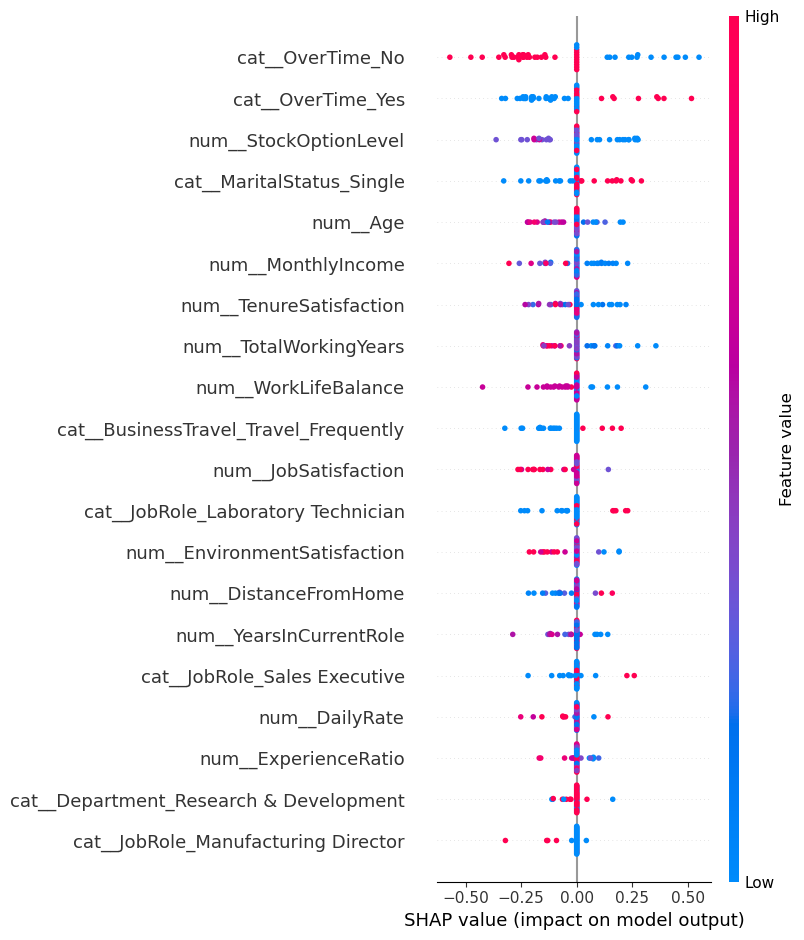

In [37]:


# --- Ambil clf (Bagging) dari pipeline ---
bagging_model = bagging.named_steps["clf"]   # step terakhir di pipeline

# --- Ambil X_train yang sudah preprocessed (hasil pipeline sebelum SMOTE) ---
# preprocessed_X_train: data training setelah preprocessing
# preprocessed_X_test : data test setelah preprocessing
# (pastikan Anda sudah simpan ini sebelumnya saat fitting pipeline)

# Gunakan background data lebih kecil biar cepat
background = shap.sample(preprocessed_X_train, 100)  # bisa juga shap.kmeans

# Definisikan explainer
explainer = shap.KernelExplainer(bagging_model.predict_proba, background, link="logit", progress_message=True)

# Hitung SHAP values untuk data test
shap_values = explainer.shap_values(preprocessed_X_test[:50], nsamples=100)  
# ambil sebagian dulu misalnya 50 sample biar cepat

# Tampilkan summary plot
shap.summary_plot(shap_values[:, :, 1] , preprocessed_X_test[:50], feature_names=feature_names)


>### Bias & Fairness Analysis

In [39]:
# === 2. Prediksi pakai model ===
y_pred = bagging.predict(X_test)
y_true = y_test.copy()

df_eval = X_test.copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred

# === 3. Buat kategori MonthlyIncome (Low, Mid, High) ===
if "MonthlyIncome" in df_eval.columns:
    df_eval["IncomeGroup"] = pd.qcut(
        df_eval["MonthlyIncome"], q=3, labels=["Low", "Mid", "High"]
    )
else:
    df_eval["IncomeGroup"] = "Unknown"

# === 4. Ambil estimator terakhir dari pipeline ===
try:
    final_est = bagging.named_steps[list(bagging.named_steps.keys())[-1]]
except:
    final_est = bagging

# === 5. Ambil feature names dari preprocessing ===
try:
    preprocessor = bagging.named_steps[list(bagging.named_steps.keys())[0]]
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
except:
    feature_names = X_test.columns

# === 6. Ambil feature importances (jika ada) ===
try:
    importances = pd.Series(final_est.feature_importances_, index=feature_names)
except AttributeError:
    importances = pd.Series([0] * len(feature_names), index=feature_names)

top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print("Top 3 Features (by importance):", top_features)

# === 7. Faktor bisnis utama ===
business_features = ["OverTime", "IncomeGroup", "JobRole"]
features_to_check = list(set(top_features + business_features))
print("Features to check fairness:", features_to_check)

# === 8. Uji fairness ===
results = {}
for feat in features_to_check:
    if feat not in df_eval.columns:
        continue
    results[feat] = {}
    for group, subset in df_eval.groupby(feat):
        if len(subset) > 5:
            report = classification_report(
                subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
            )
            results[feat][group] = report["weighted avg"]

# === 9. Print hasil ===
for feat, groups in results.items():
    print(f"\n=== Fairness check by {feat} ===")
    for group, metrics in groups.items():
        print(f"  {group}: F1={metrics['f1-score']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

Top 3 Features (by importance): ['num__Age', 'cat__JobRole_Manager', 'cat__EducationField_Life Sciences']
Features to check fairness: ['IncomeGroup', 'num__Age', 'cat__JobRole_Manager', 'OverTime', 'cat__EducationField_Life Sciences', 'JobRole']

=== Fairness check by IncomeGroup ===
  Low: F1=0.777, Precision=0.774, Recall=0.786
  Mid: F1=0.848, Precision=0.845, Recall=0.867
  High: F1=0.921, Precision=0.943, Recall=0.939

=== Fairness check by OverTime ===
  No: F1=0.875, Precision=0.849, Recall=0.904
  Yes: F1=0.745, Precision=0.747, Recall=0.750

=== Fairness check by JobRole ===
  Healthcare Representative: F1=0.809, Precision=0.756, Recall=0.870
  Human Resources: F1=0.818, Precision=0.818, Recall=0.818
  Laboratory Technician: F1=0.876, Precision=0.892, Recall=0.864
  Manager: F1=1.000, Precision=1.000, Recall=1.000
  Manufacturing Director: F1=0.862, Precision=0.821, Recall=0.906
  Research Director: F1=0.913, Precision=0.886, Recall=0.941
  Research Scientist: F1=0.784, Precis

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\1130321592.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df_eval.groupby(feat):


## MODEL 4 - ADABOOST CLASSIFIER

In [41]:
adaboost.fit(X_train, y_train)
y_pred  = adaboost.predict(X_test)
y_proba = adaboost.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.p


=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.8764    0.9757    0.9234       247
           1     0.6842    0.2766    0.3939        47

    accuracy                         0.8639       294
   macro avg     0.7803    0.6262    0.6587       294
weighted avg     0.8456    0.8639    0.8387       294

Test ROC-AUC: 0.8201
Test F2: 0.3140096618357488


>### Feature Importance

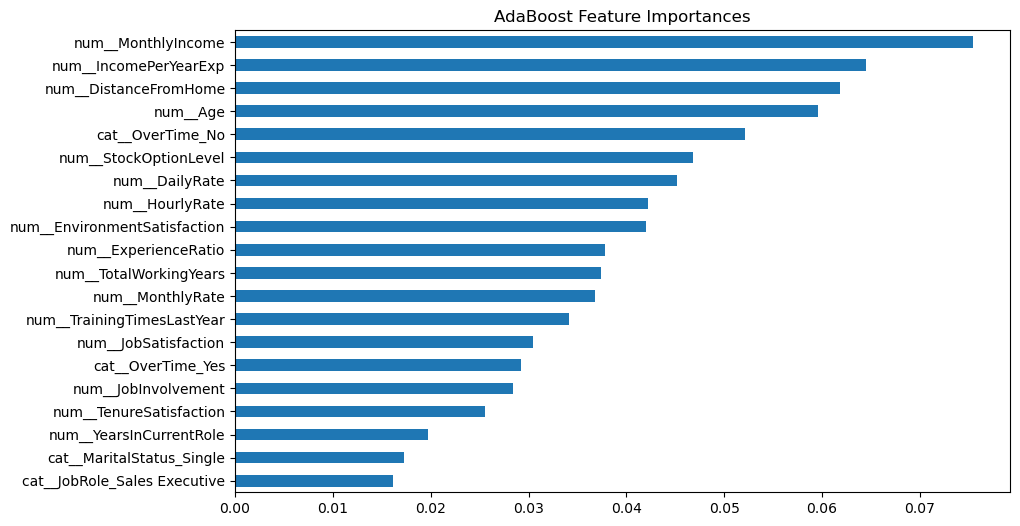

In [43]:
model_ada = adaboost.named_steps["clf"]   # ambil dari pipeline
importances_ada = model_ada.feature_importances_

feat_importances_ada = pd.Series(importances_ada, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances_ada.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("AdaBoost Feature Importances")
plt.show()

>### SHAP Values

In [45]:
expl_ada, shap_ada, X_test_ada = get_shap_general(
    pipeline=adaboost, 
    X_train=X_train, 
    X_test=X_test, 
    model_type="kernel",    
    n_background=200, 
    method="sample",
    n_test_samples=200,
    nsample_kernel=200 
)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

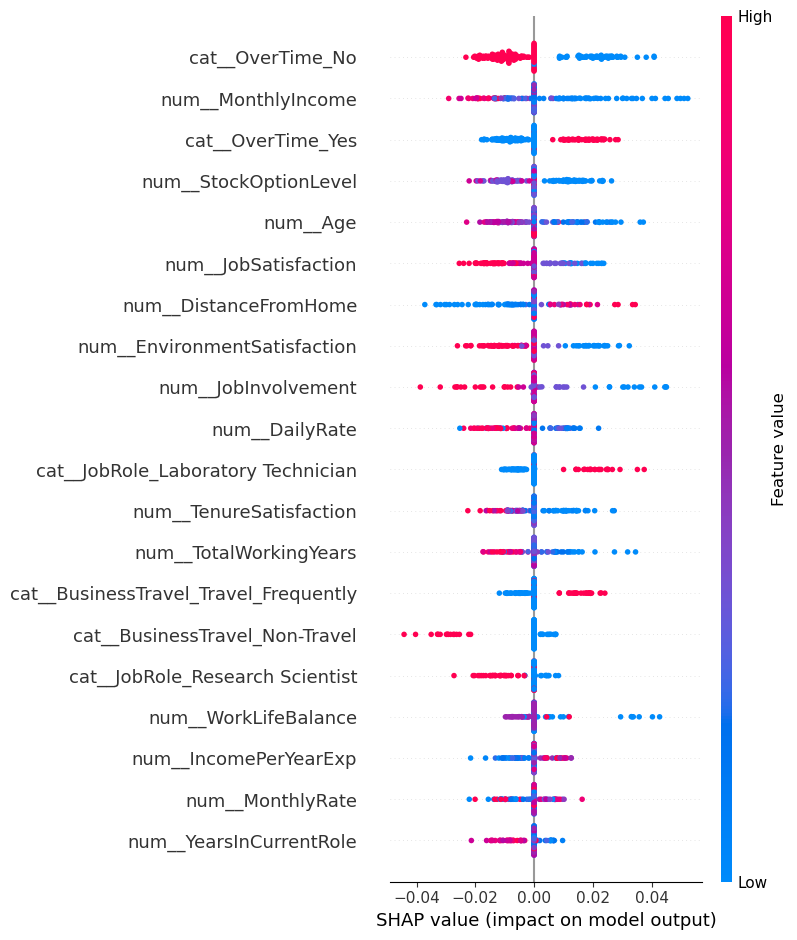

In [46]:
shap.summary_plot(
    shap_ada, 
    X_test_ada[:200],                        # bisa ganti slice sesuai kebutuhan
    feature_names=feature_names,  # nama kolom dari preprocessor
    show=True)

>### Bias & Fairness Analysis

In [48]:
# === 2. Prediksi pakai model ===
y_pred = adaboost.predict(X_test)
y_true = y_test.copy()

df_eval = X_test.copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred

# === 3. Buat kategori MonthlyIncome (Low, Mid, High) ===
if "MonthlyIncome" in df_eval.columns:
    df_eval["IncomeGroup"] = pd.qcut(
        df_eval["MonthlyIncome"], q=3, labels=["Low", "Mid", "High"]
    )
else:
    df_eval["IncomeGroup"] = "Unknown"

# === 4. Ambil estimator terakhir dari pipeline ===
try:
    final_est = adaboost.named_steps[list(adaboost.named_steps.keys())[-1]]
except:
    final_est = adaboost

# === 5. Ambil feature names dari preprocessing ===
try:
    preprocessor = adaboost.named_steps[list(adaboost.named_steps.keys())[0]]
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
except:
    feature_names = X_test.columns

# === 6. Ambil feature importances (jika ada) ===
try:
    importances = pd.Series(final_est.feature_importances_, index=feature_names)
except AttributeError:
    importances = pd.Series([0] * len(feature_names), index=feature_names)

top_features = importances.sort_values(ascending=False).head(3).index.tolist()
print("Top 3 Features (by importance):", top_features)

# === 7. Faktor bisnis utama ===
business_features = ["OverTime", "IncomeGroup", "JobRole"]
features_to_check = list(set(top_features + business_features))
print("Features to check fairness:", features_to_check)

# === 8. Uji fairness ===
results = {}
for feat in features_to_check:
    if feat not in df_eval.columns:
        continue
    results[feat] = {}
    for group, subset in df_eval.groupby(feat):
        if len(subset) > 5:
            report = classification_report(
                subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
            )
            results[feat][group] = report["weighted avg"]

# === 9. Print hasil ===
for feat, groups in results.items():
    print(f"\n=== Fairness check by {feat} ===")
    for group, metrics in groups.items():
        print(f"  {group}: F1={metrics['f1-score']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

Top 3 Features (by importance): ['num__MonthlyIncome', 'num__IncomePerYearExp', 'num__DistanceFromHome']
Features to check fairness: ['JobRole', 'IncomeGroup', 'OverTime', 'num__DistanceFromHome', 'num__IncomePerYearExp', 'num__MonthlyIncome']

=== Fairness check by JobRole ===
  Healthcare Representative: F1=0.809, Precision=0.756, Recall=0.870
  Human Resources: F1=0.896, Precision=0.918, Recall=0.909
  Laboratory Technician: F1=0.843, Precision=0.823, Recall=0.864
  Manager: F1=1.000, Precision=1.000, Recall=1.000
  Manufacturing Director: F1=0.862, Precision=0.821, Recall=0.906
  Research Director: F1=0.913, Precision=0.886, Recall=0.941
  Research Scientist: F1=0.767, Precision=0.811, Recall=0.806
  Sales Executive: F1=0.887, Precision=0.915, Recall=0.906
  Sales Representative: F1=0.690, Precision=0.688, Recall=0.696

=== Fairness check by IncomeGroup ===
  Low: F1=0.749, Precision=0.753, Recall=0.776
  Mid: F1=0.847, Precision=0.864, Recall=0.878
  High: F1=0.921, Precision=0.94

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\1017048403.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df_eval.groupby(feat):


## MODEL 5 - XGBOOST CLASSIFIER

In [50]:
xgb_pipe.fit(X_train, y_train)
y_pred  = xgb_pipe.predict(X_test)
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.8736    0.9514    0.9109       247
           1     0.5200    0.2766    0.3611        47

    accuracy                         0.8435       294
   macro avg     0.6968    0.6140    0.6360       294
weighted avg     0.8171    0.8435    0.8230       294

Test ROC-AUC: 0.7879
Test F2: 0.3051643192488263


>### Feature Importance

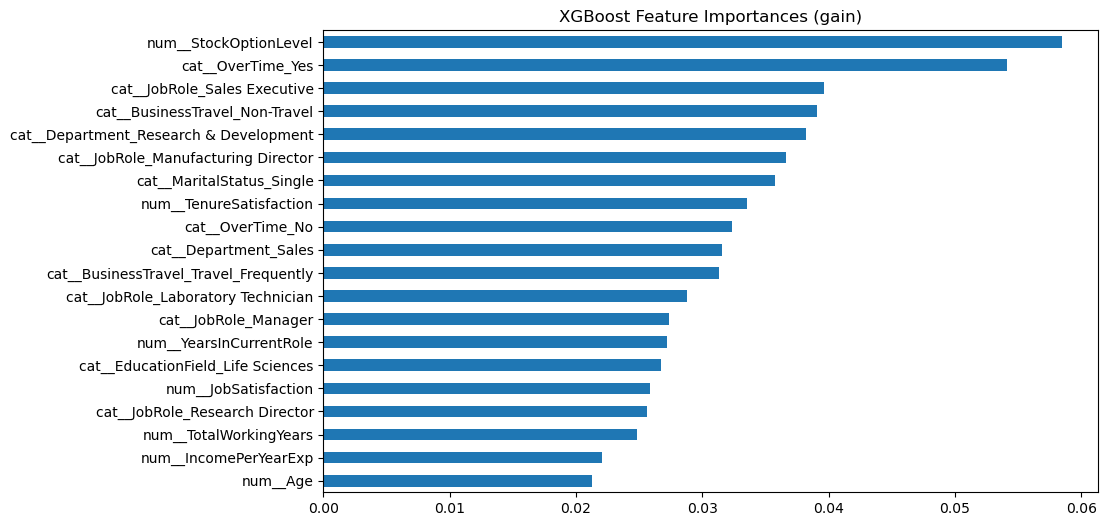

In [52]:
model_xgb = xgb.named_steps["clf"]

# Ambil importance type = "gain" (paling umum)
importances_xgb = model_xgb.feature_importances_

feat_importances_xgb = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances_xgb.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances (gain)")
plt.show()


>### SHAP Values

In [54]:
expl_xgb, shap_xgb, X_test_xgb = get_shap_general(
    pipeline=xgb_pipe, 
    X_train=X_train, 
    X_test=X_test, 
    model_type="tree"
)

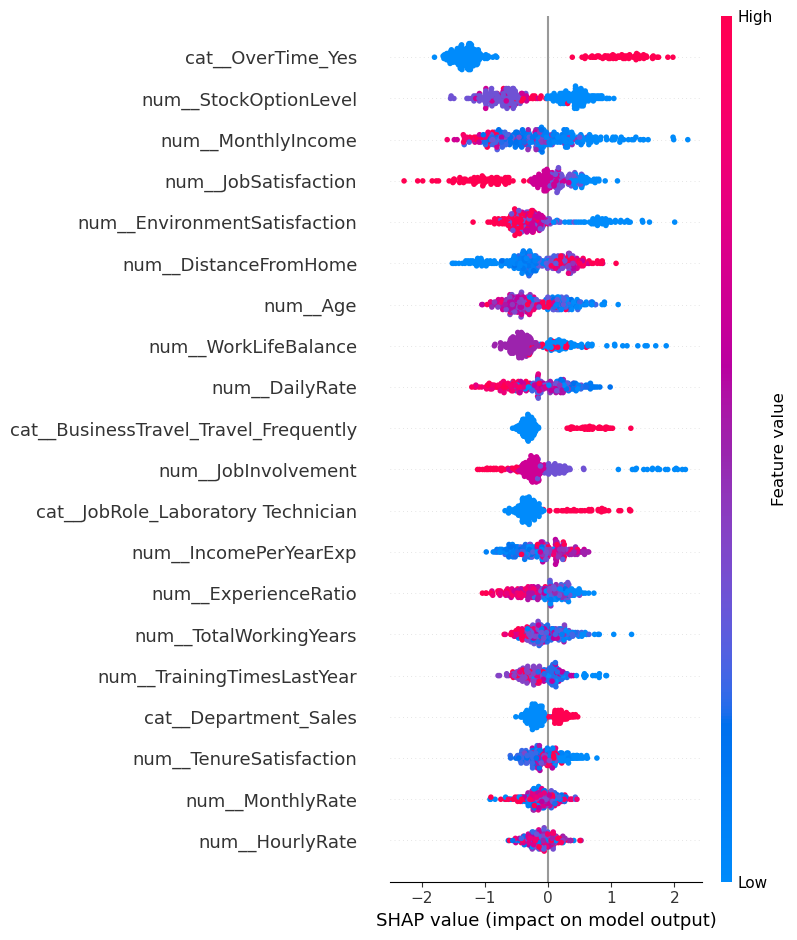

In [55]:
shap.summary_plot(
    shap_xgb, 
    X_test_xgb,                        # bisa ganti slice sesuai kebutuhan
    feature_names=feature_names,  # nama kolom dari preprocessor
    show=True)

>### Bias & Fairness Analysis

In [57]:
# === Prediksi di data test ===
y_pred = xgb_pipe.predict(X_test)
print("=== Overall Performance on Test Data ===")
print(classification_report(y_test, y_pred))

# === Fairness check by MonthlyIncome (Low, Mid, High) ===
X_test_fair = X_test.copy()
X_test_fair["y_true"] = y_test
X_test_fair["y_pred"] = y_pred

# bikin kategori income
X_test_fair["IncomeGroup"] = pd.qcut(
    X_test_fair["MonthlyIncome"], 
    q=3, 
    labels=["Low", "Mid", "High"]
)

print("\n=== Fairness check by MonthlyIncome ===")
for group, df_group in X_test_fair.groupby("IncomeGroup"):
    print(f"\nGroup: {group}")
    print(classification_report(df_group["y_true"], df_group["y_pred"], zero_division=0))

# === Fairness check by JobRole ===
print("\n=== Fairness check by JobRole ===")
for role, df_group in X_test_fair.groupby("JobRole"):
    print(f"\n{role}:")
    print(classification_report(df_group["y_true"], df_group["y_pred"], zero_division=0))

# === Fairness check by OverTime ===
print("\n=== Fairness check by OverTime ===")
for ot, df_group in X_test_fair.groupby("OverTime"):
    print(f"\n{ot}:")
    print(classification_report(df_group["y_true"], df_group["y_pred"], zero_division=0))

=== Overall Performance on Test Data ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       247
           1       0.52      0.28      0.36        47

    accuracy                           0.84       294
   macro avg       0.70      0.61      0.64       294
weighted avg       0.82      0.84      0.82       294


=== Fairness check by MonthlyIncome ===

Group: Low
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        73
           1       0.50      0.32      0.39        25

    accuracy                           0.74        98
   macro avg       0.65      0.61      0.61        98
weighted avg       0.72      0.74      0.72        98


Group: Mid
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        84
           1       0.75      0.21      0.33        14

    accuracy                           0.88        98
   macro avg       0.8

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\3402923096.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df_group in X_test_fair.groupby("IncomeGroup"):


## MODEL 6 - STACKING

In [59]:
stack.fit(X_train, y_train)
y_pred  = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))
f2 = fbeta_score(y_test, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.9073    0.9109    0.9091       247
           1     0.5217    0.5106    0.5161        47

    accuracy                         0.8469       294
   macro avg     0.7145    0.7108    0.7126       294
weighted avg     0.8456    0.8469    0.8463       294

Test ROC-AUC: 0.8282
Test F2: 0.5128205128205128


>### Feature Importance

In [61]:
stack_model = stack.named_steps["clf"]

# --- Random Forest ---
rf = stack_model.named_estimators_["rf"]
rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# --- Bagging ---
bag = stack_model.named_estimators_["bagging"]
all_importances = []
for est, feat_idx in zip(bag.estimators_, bag.estimators_features_):
    imp = np.zeros(len(feature_names))
    imp[feat_idx] = est.feature_importances_
    all_importances.append(imp)
bag_importances = pd.Series(np.mean(all_importances, axis=0), index=feature_names).sort_values(ascending=False)

# --- Logistic Regression ---
log = stack_model.named_estimators_["logreg"]
log_importances = pd.Series(np.abs(log.coef_[0]), index=feature_names).sort_values(ascending=False)

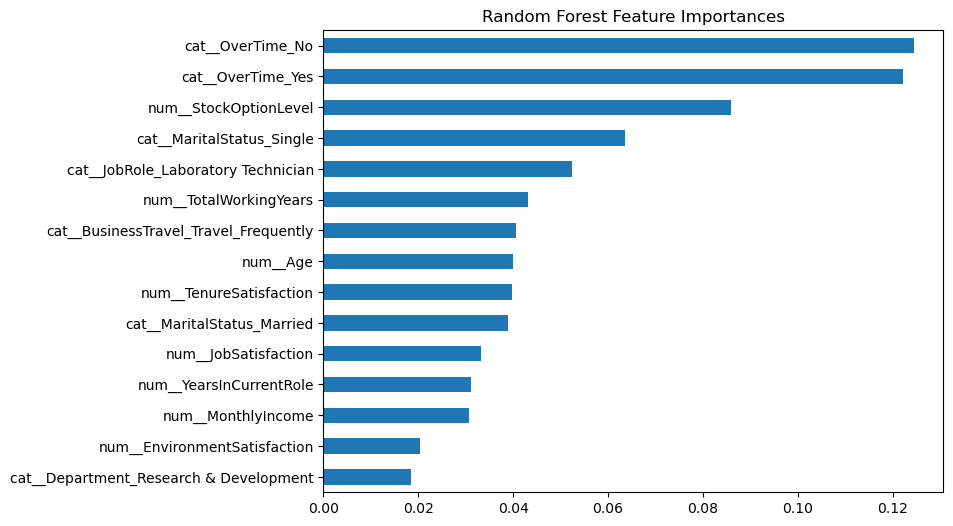

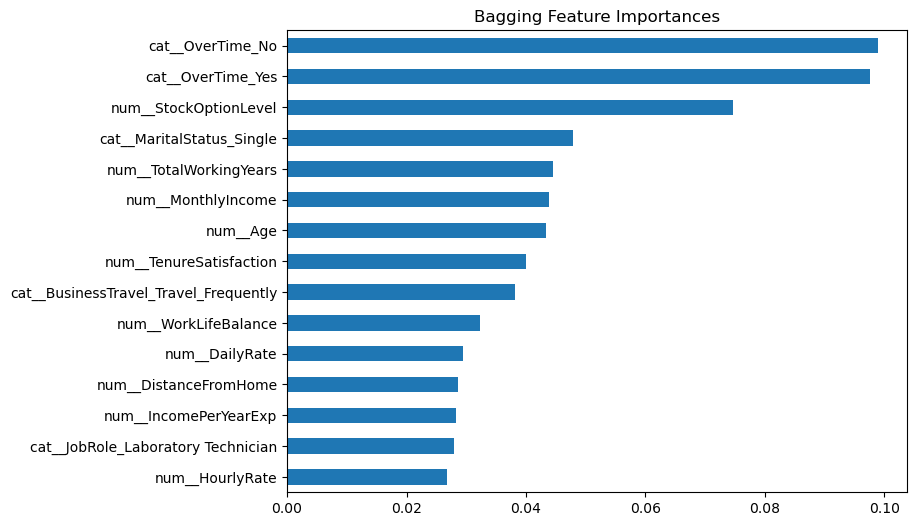

In [62]:
def plot_importances(importances, title, top_n=15):
    plt.figure(figsize=(8,6))
    importances.head(top_n).plot(kind="barh")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Random Forest
plot_importances(rf_importances, "Random Forest Feature Importances")

# Bagging
plot_importances(bag_importances, "Bagging Feature Importances")

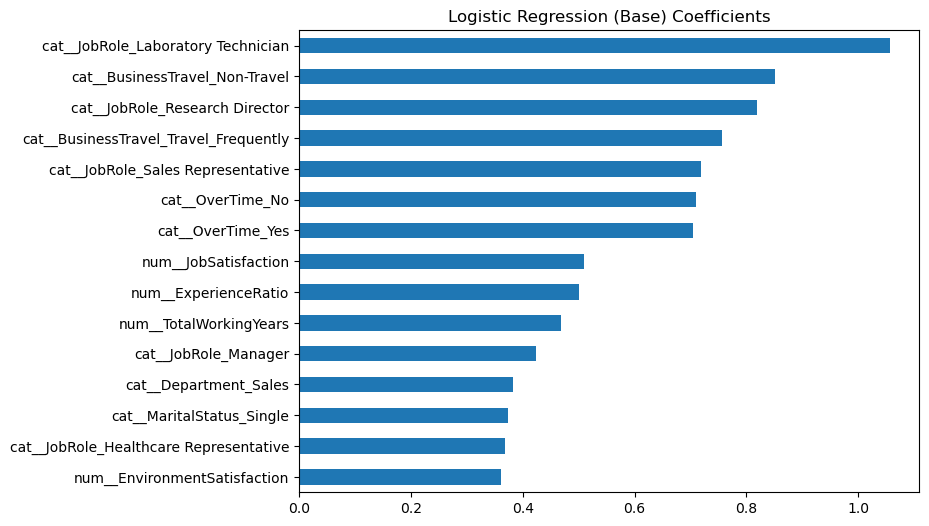

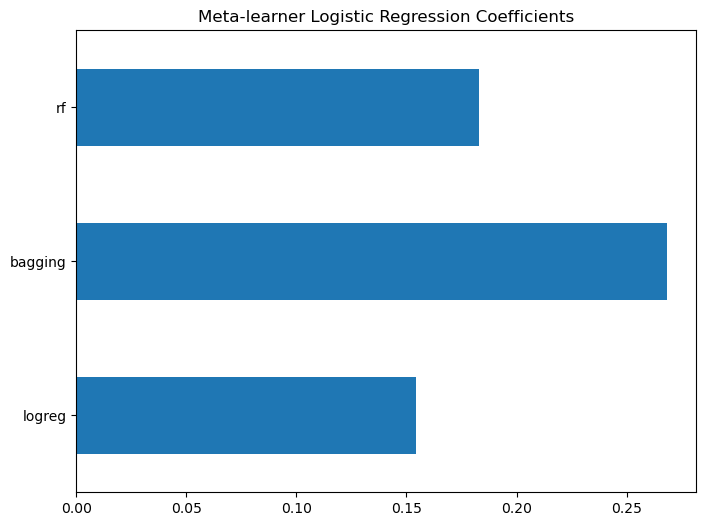

In [66]:
# Base learner: logreg
plot_importances(log_importances.abs(), "Logistic Regression (Base) Coefficients")

# Final estimator: logistic regression (meta learner)
meta = stack.named_steps["clf"].final_estimator_
meta_coefs = pd.Series(meta.coef_[0], 
                       index=stack.named_steps["clf"].named_estimators_.keys())
plot_importances(meta_coefs.abs(), "Meta-learner Logistic Regression Coefficients")

>### SHAP Values

In [69]:
expl_stack, shap_stack, X_test_stack = get_shap_general(
    pipeline=stack, 
    X_train=X_train, 
    X_test=X_test, 
    model_type="kernel",    
    n_background=200, 
    method="sample",
    n_test_samples=200,
    nsample_kernel=200 
)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

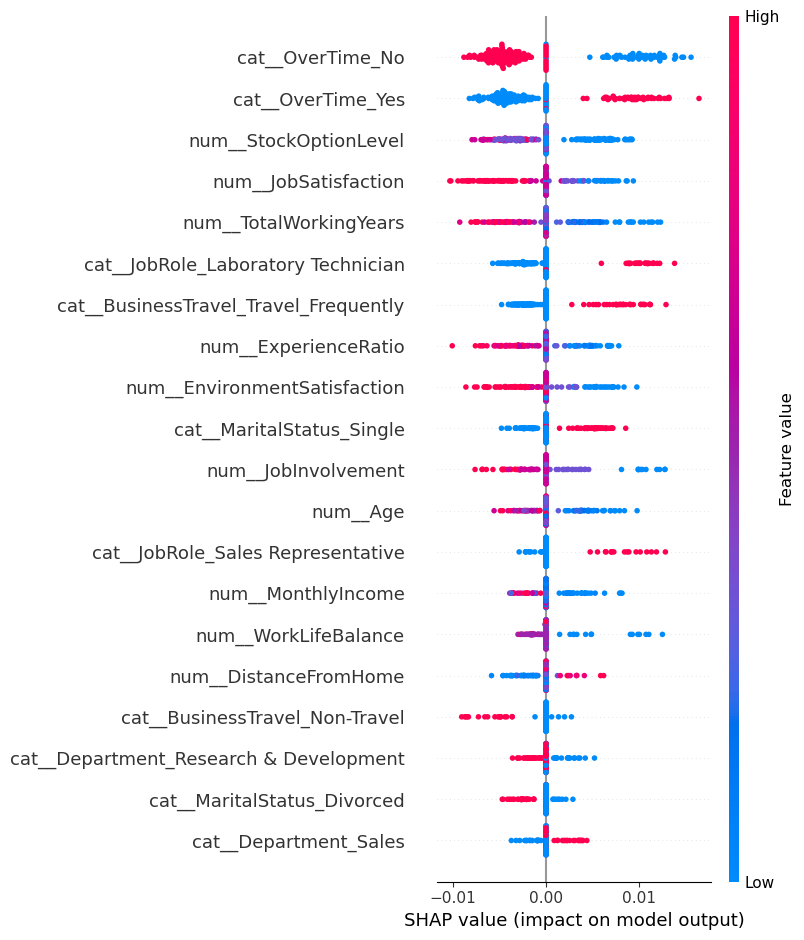

In [70]:
shap.summary_plot(
    shap_stack, 
    X_test_stack[:200],                        
    feature_names=feature_names,  
    show=True)

In [71]:
stack.fit(X_train, y_train)
y_pred  = stack.predict(X_train)
y_proba = stack.predict_proba(X_train)[:, 1]
print("\n=== TEST REPORT ===")
print(classification_report(y_train, y_pred, digits=4))
print("Test ROC-AUC:", roc_auc_score(y_train, y_proba).round(4))
f2 = fbeta_score(y_train, y_pred, beta=2)
print("Test F2:", f2)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== TEST REPORT ===
              precision    recall  f1-score   support

           0     0.9591    0.9757    0.9673       986
           1     0.8613    0.7842    0.8209       190

    accuracy                         0.9447      1176
   macro avg     0.9102    0.8799    0.8941      1176
weighted avg     0.9433    0.9447    0.9437      1176

Test ROC-AUC: 0.9775
Test F2: 0.7984994640943194


>### Bias & Fairness Analysis

In [73]:
# === 2. Prediksi pakai model ===
y_pred = stack.predict(X_test)
y_true = y_test.copy()

df_eval = X_test.copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred

# === 3. Buat kategori MonthlyIncome (Low, Mid, High) ===
if "MonthlyIncome" in df_eval.columns:
    df_eval["IncomeGroup"] = pd.qcut(
        df_eval["MonthlyIncome"], q=3, labels=["Low", "Mid", "High"]
    )
else:
    df_eval["IncomeGroup"] = "Unknown"

# === 4. Ambil estimator terakhir dari pipeline ===
try:
    final_est = stack.named_steps[list(stack.named_steps.keys())[-1]]
except:
    final_est = stack

# === 5. Ambil feature names dari preprocessing ===
try:
    preprocessor = stack.named_steps[list(stack.named_steps.keys())[0]]
    feature_names = preprocessor.get_feature_names_out(X_test.columns)
except:
    feature_names = X_test.columns

# === 6. Ambil feature importances (cek apakah ada) ===
try:
    importances = pd.Series(final_est.feature_importances_, index=feature_names)
    top_features = importances.sort_values(ascending=False).head(3).index.tolist()
except AttributeError:
    # kalau Stacking biasanya tidak punya feature_importances_
    top_features = ["MonthlyIncome", "OverTime", "JobRole"]

print("Top 3 Features (by importance or predefined):", top_features)

# === 7. Faktor bisnis utama ===
business_features = ["OverTime", "IncomeGroup", "JobRole"]
features_to_check = list(set(top_features + business_features))
print("Features to check fairness:", features_to_check)

# === 8. Uji fairness ===
results = {}
for feat in features_to_check:
    if feat not in df_eval.columns:
        continue
    results[feat] = {}
    for group, subset in df_eval.groupby(feat):
        if len(subset) > 5:
            report = classification_report(
                subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
            )
            results[feat][group] = report["weighted avg"]

# === 9. Print hasil ===
for feat, groups in results.items():
    print(f"\n=== Fairness check by {feat} ===")
    for group, metrics in groups.items():
        print(f"  {group}: F1={metrics['f1-score']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")

Top 3 Features (by importance or predefined): ['MonthlyIncome', 'OverTime', 'JobRole']
Features to check fairness: ['MonthlyIncome', 'IncomeGroup', 'JobRole', 'OverTime']

=== Fairness check by MonthlyIncome ===

=== Fairness check by IncomeGroup ===
  Low: F1=0.796, Precision=0.796, Recall=0.796
  Mid: F1=0.841, Precision=0.846, Recall=0.837
  High: F1=0.898, Precision=0.892, Recall=0.908

=== Fairness check by JobRole ===
  Healthcare Representative: F1=0.809, Precision=0.756, Recall=0.870
  Human Resources: F1=0.747, Precision=0.777, Recall=0.727
  Laboratory Technician: F1=0.866, Precision=0.913, Recall=0.841
  Manager: F1=1.000, Precision=1.000, Recall=1.000
  Manufacturing Director: F1=0.862, Precision=0.821, Recall=0.906
  Research Director: F1=0.913, Precision=0.886, Recall=0.941
  Research Scientist: F1=0.779, Precision=0.777, Recall=0.792
  Sales Executive: F1=0.887, Precision=0.887, Recall=0.887
  Sales Representative: F1=0.701, Precision=0.774, Recall=0.696

=== Fairness ch

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11076\2269454573.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, subset in df_eval.groupby(feat):


>### Threshold for Stacking Model

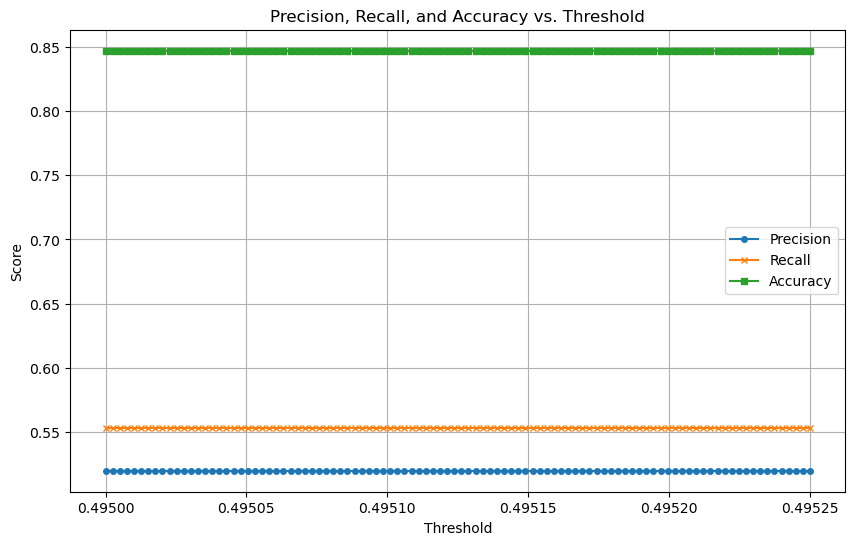

In [75]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score

y_pred_proba = stack.predict_proba(X_test)[:, 1]

# 5. Menentukan rentang ambang batas yang akan diuji
thresholds = np.linspace(0.495, 0.49525, 100)

# 6. Menghitung precision, recall, dan accuracy untuk setiap ambang batas
precision_scores = []
recall_scores = []
accuracy_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Menghitung metrik
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

# 7. Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', marker='o', markersize=4)
plt.plot(thresholds, recall_scores, label='Recall', marker='x', markersize=4)
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='s', markersize=4)

plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
feature_names

array(['num__Age', 'num__DailyRate', 'num__DistanceFromHome',
       'num__EnvironmentSatisfaction', 'num__HourlyRate',
       'num__JobInvolvement', 'num__JobSatisfaction',
       'num__MonthlyIncome', 'num__MonthlyRate', 'num__StockOptionLevel',
       'num__TotalWorkingYears', 'num__TrainingTimesLastYear',
       'num__WorkLifeBalance', 'num__YearsInCurrentRole',
       'num__ExperienceRatio', 'num__IncomePerYearExp',
       'num__TenureSatisfaction', 'cat__BusinessTravel_Non-Travel',
       'cat__BusinessTravel_Travel_Frequently',
       'cat__BusinessTravel_Travel_Rarely',
       'cat__Department_Human Resources',
       'cat__Department_Research & Development', 'cat__Department_Sales',
       'cat__EducationField_Human Resources',
       'cat__EducationField_Life Sciences',
       'cat__EducationField_Marketing', 'cat__EducationField_Medical',
       'cat__EducationField_Other',
       'cat__EducationField_Technical Degree',
       'cat__JobRole_Healthcare Representative',
      

In [77]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'EducationField', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'OverTime',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsInCurrentRole', 'ExperienceRatio',
       'IncomePerYearExp', 'TenureSatisfaction'],
      dtype='object')